In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  # specialised naive bayes
from sklearn.metrics import accuracy_score  # to determine accuracy test
from sklearn.multiclass import OneVsRestClassifier  #  create multiple binary classifications in case of multiple classes
from sklearn.svm import LinearSVC  # SVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv("train.csv")  # using pandas


In [3]:
df.head()  # prints first 5 rows of the dataset

,id,comment_text,weekly negative,strongly negative,negative,threat
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0


In [4]:
missing_values_check = df.isnull().sum()
print(missing_values_check)

id                   0
comment_text         0
weekly negative      0
strongly negative    0
negative             0
threat               0
dtype: int64


In [5]:
#neutral comments
neutral = df[(df['weekly negative'] == 0) & (df['negative'] == 0) & (df['strongly negative'] == 0) & (df['threat'] == 0) ]
neutral.shape


(143729, 6)

In [6]:
COLUMNS = ['weekly negative', 'negative', 'strongly negative', 'threat']
# Adding 'clean' columns if there is no '1' in COLUMNS
df['neutral'] = (df[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('neutral')

In [7]:
df.head()

,id,comment_text,weekly negative,strongly negative,negative,threat,neutral
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,1


In [8]:
#frequency of occurence of multilabelled data
label = df[['weekly negative', 'negative', 'strongly negative', 'threat','neutral']]
rowSums = label.sum(axis=1)
multiLabel_counts = rowSums.value_counts()

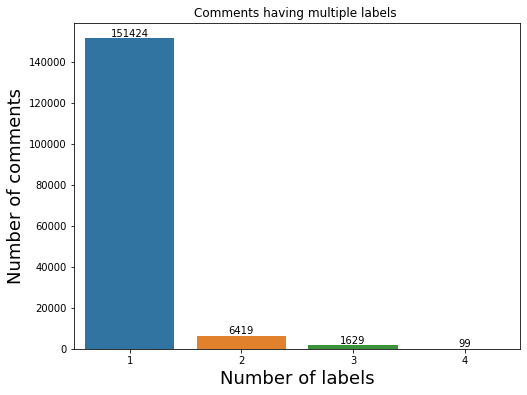

In [9]:
plt.figure(figsize=(8,6))
ax = sns.barplot( x = multiLabel_counts.index, y = multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()


average length of comment: 393.544


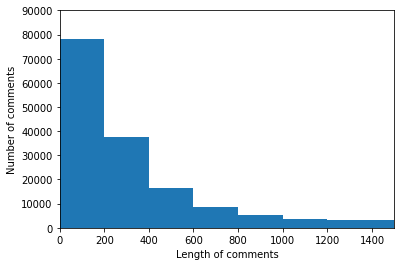

In [10]:
#length of comments(chacterwise)
comment = df['comment_text']
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200,1500]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1500, 0, 90000])
plt.show()

In [11]:
#label combination
df_comb = df.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,weekly negative,negative,strongly negative,threat,neutral,count
0,0,0,0,0,1,143729
1,1,0,0,0,0,7151
2,1,1,0,0,0,6211
3,1,1,1,0,0,1418
4,0,1,0,0,0,519
5,1,1,0,1,0,198
6,1,0,0,1,0,139
7,1,1,1,1,0,99
8,1,0,1,0,0,65
9,0,0,0,1,0,25


<AxesSubplot:>

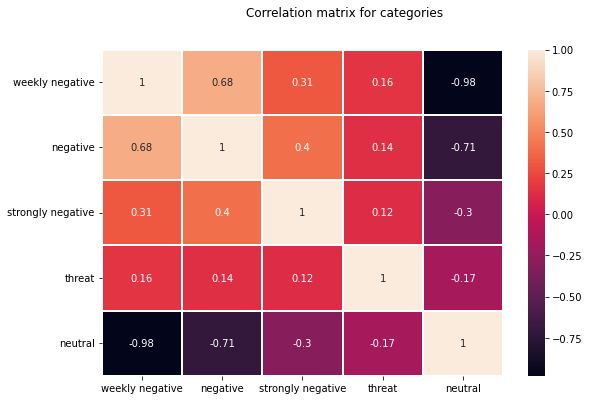

In [12]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df[COLUMNS].corr(), annot=True, linewidths=2, ax=ax)

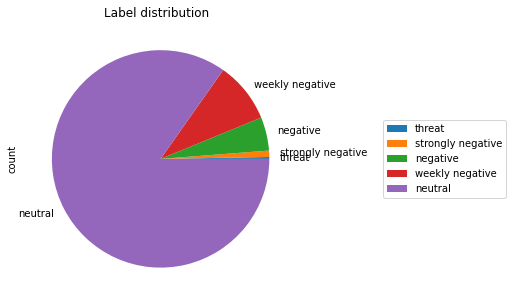

In [13]:
lab=df[COLUMNS].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')
lab.plot.pie(y='count',title='Label distribution  ',figsize=(5, 5)).legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#Removing stop words
stop_words = set(stopwords.words('english'))  #load stopwords from english dict
#below adding few stopwords
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df['comment_text'] = df['comment_text'].apply(removeStopWords)
print(df.head())

                 id                                       comment_text  \
0  0000997932d777bf  Explanation\n  edits made   username Hardcore ...   
1  000103f0d9cfb60f   aww!  matches  background colour   seemingly ...   
2  000113f07ec002fd  Hey man,   really  trying  edit war.     guy  ...   
3  0001b41b1c6bb37e  "\n    make  real suggestions  improvement -  ...   
4  0001d958c54c6e35           sir,   hero.  chance  remember  page       

   weekly negative  strongly negative  negative  threat  neutral  
0                0                  0         0       0        1  
1                0                  0         0       0        1  
2                0                  0         0       0        1  
3                0                  0         0       0        1  
4                0                  0         0       0        1  


In [16]:
print(df['comment_text'][0])

Explanation
  edits made   username Hardcore Metallica Fan  reverted?    vandalisms,  closure   GAs   voted  New York Dolls FAC.  please   remove  template   talk page since   retired  89.205.38.27


In [17]:
#cleanning puntuation
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n', ' ', text)
    text = text.strip(' ')
    return text

df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

df['comment_text'][0]

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired 89 205 38 27'

In [18]:
#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df['comment_text'] = df['comment_text'].apply(stemming)
df.head()

,id,comment_text,weekly negative,strongly negative,negative,threat,neutral
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,1
1,000103f0d9cfb60f,aww match background colour seem stuck thank t...,0,0,0,0,1
2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,1
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,1
4,0001d958c54c6e35,sir hero chanc rememb page,0,0,0,0,1


# spliting into train and test

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)
print(train.shape)
print(test.shape)

(111699, 7)
(47872, 7)


In [20]:
train_text = train['comment_text']
test_text = test['comment_text']

In [54]:
#OneVsRestClassifier(MultinomialNB)
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

precision_arr = []
recall_arr = []
for category in COLUMNS:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(train_text , train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(test_text )
    print('Test accuracy is', accuracy_score(test[category], prediction) * 100 , '%')
    
    precision = precision_score(test[category], prediction, average='macro')
    precision_arr.append(precision)
    
    recall = recall_score(test[category], prediction, average='macro')
    recall_arr.append(recall)

print()
print("precision : {},  Recall : {}".format(sum(precision_arr)/5, sum(recall_arr)/5) )


... Processing weekly negative
Test accuracy is 92.08514371657755 %
... Processing negative
Test accuracy is 95.18716577540107 %
... Processing strongly negative
Test accuracy is 98.98270387700535 %
... Processing threat
Test accuracy is 99.7179979946524 %
... Processing neutral
Test accuracy is 91.99532085561498 %

precision : 0.8743549721753482,  Recall : 0.5475392179926487


In [52]:
# OneVsRestClassifier(LinearSVC() SVM
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])


precision_arr = []
recall_arr = []
for category in COLUMNS:
    
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(train_text, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(test_text )
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print()
    
    precision = precision_score(test[category], prediction, average='macro')
    precision_arr.append(precision)
    
    recall = recall_score(test[category], prediction, average='macro')
    recall_arr.append(recall)
    
print("precision : {},  Recall : {}".format(sum(precision_arr)/5, sum(recall_arr)/5) )

    

... Processing weekly negative
Test accuracy is 0.9606868315508021

... Processing negative
Test accuracy is 0.9792780748663101

... Processing strongly negative
Test accuracy is 0.9904745989304813

... Processing threat
Test accuracy is 0.9973470922459893

... Processing neutral
Test accuracy is 0.9615641711229946

precision : 0.8711220761968645,  Recall : 0.7553110869561033


In [51]:
precision_arr

[0.9263471378317877]